# Ensemble Methods

What is an *Ensemble*? If the word rhymes with 'assemble' and 'resemble', that's not a conincidence. Ensembles are **meta algorithms** that combine a variety of learners into one predictive model.

The Wiki definition says this:

> In statistics and machine learning, ensemble methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone.

How exactly does a combo or team of algos do better than any single algo alone? In one of three ways.

1. by reducing variance (Bagging)

2. by reducing bias (Boosting)

3. by stacking 

The firsttwo points above refer to the famnous **bias-variance tradeoff** in ML (and Stats in general).

Let's explore some of this. Starting off as usual with the setup chunk. 

In [1]:
# setup chunk
import mglearn
import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score

# import required ensemble classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

C:\Users\20052\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
C:\Users\20052\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Custom-building an Ensemble of Methods
 
Here's the plan. 

- First, we next simulate a dummy dataset.

- Second, we select a bouquet of individual classifiers such as Logistic, SVC, RF etc

- Third, we bundle together the results of these individual classifiers and create an ensemble

- Fourth, we apply the ensemble to the data directly and examine results. 

So what classifiers will we choose? Here's what I have in mind for the dummy dataset.

- Random Forests or RF (ensemble of D-trees)
- Logistic Regressions
- Support vector Classifier (SVC)

So let's get started. First, we simulate dummy data.

(500, 2)
[1 0 1 0 0 1 1 0]


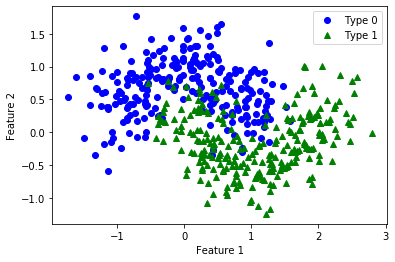

In [2]:
# simulate dummy data
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

# explore data dimns
print(X.shape)
print(y[:8])

# explore data pattern by plotting
plt.plot(X[:,0][y==0], X[:,1][y==0], 'bo', label = "Type 0")
plt.plot(X[:,0][y==1], X[:,1][y==1], 'g^', label = "Type 1")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2") 
plt.legend()
plt.show()

Next steps we should be familiar with by now. Such as

- train-test splitting to validate classifier perf on test sample

- instantiating model and fitting to training data

What changes however is our use of the **votingClassifier** class to combine these individual classifiers into one single ensemble method.

We fit only the ensemble to training data directly, not each individual model in the ensemble. Convenient, no?

In [3]:
# train-test-split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape)

# import required ensemble classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# instantiate the  ensemble models with set random_state for reproducibility
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", random_state=42)

# combine them in a voting wrapper
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

# fit ensemble wrapper to training data
voting_clf.fit(X_train, y_train)

(375, 2)


VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,...
                                        

Time now to head to results and an evaluation of ensemble perf.

But alongside that, makes sense to see how well individual models do on their own. Can then compare them against the ensemble model.

Behold.

In [4]:
from sklearn.metrics import accuracy_score

# instantiate models 
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", probability=True, random_state=42)

# for-loop over models and print perf score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)    
    y_pred = clf.predict(X_train)  # ensemble class too has its own predict method!
    print(clf.__class__.__name__, round(accuracy_score(y_train, y_pred), 3))


LogisticRegression 0.843
RandomForestClassifier 0.995
SVC 0.909
VotingClassifier 0.923


On training data, accuracy perf ranges between 84% for LogReg to 99.5% for RF.

RF is likely **overfitting** the data given its ridiculuous accuracy fig.

The ensemble given by 'Voting Classifier' is at a respectable 92.5%.

On the face of it, looks like the ensemble is sort of **doing a (weighted) average** of the accuracies of the component classfiers, right?

Well, let's see what happens on test data, which anyway is the more interesting part.

In [5]:
from sklearn.metrics import accuracy_score

# do for test data
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


Indiv models show an accuracy perf range between 86% & 88% on test data.

Their combination however bumps up the perf to 89.6%!

Clearly, ensembles are not about mere results averaging. The ensemble is able to pick particular models for particular *tracts* of data where those models outperform the rest.

The resulting combination is one of models and not just results.

Within Ensembles, we highlight 2 approaches
- **Bagging** or Bootstrap Aggregation
- **Boosting** (Perf boost by emphasizing learning from errors)

Let's start with the first one.

## Bagging Ensembles

Bootstrapping means 
- 1. resampling (with replacement) from a dataset, 
- 2. applying an estimator to each sample thus obtained, 
- 3. and thereafter, constructing a distribution of the estimate's metrics.

In Statistics, Efron and Tibshirani famously proved that bootstrapped estimate inference is statistically kosher.

Bagging uses bootstrapping to fit each component ML algo several times on resampled slices of the data and aggregates estimates for robustness and quasi-inference.

See below.

In [6]:
# import required modules
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# define a bagging ensemble
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), 
    n_estimators=500,
    max_samples=100, 
    bootstrap=True, 
    n_jobs=-1, random_state=42)


# fit model
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

# print accuracy scores
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


90.4 % from a Bagging Ensemble. Better than the 89.4% we obtained through the Voting classifier. Cool.

Even cooler when you compare this with a stand-alone D-tree classifier. See below.

In [7]:
# standalone d-tree classifiers
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


With D-trees at 85.6%, our bagging ensemble does significantly better with a 4.8% point jump.

But what is it that bagging does really? 

Why not plot and *see* what happens at the data level? 

After all, we choose dummy data to start with precisely to be able to see the effects on data.

Below I define a custom func to plot stuff and then plot what happens in d-trees versus in bagging ensembles.

Behold.

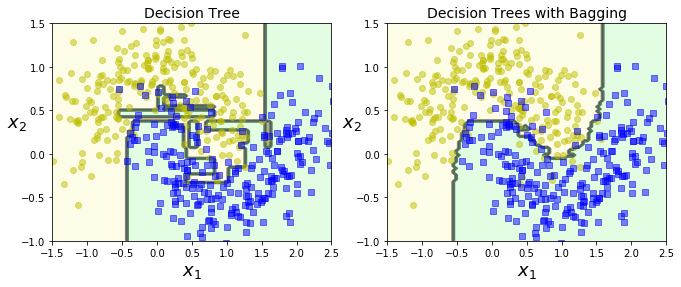

In [8]:
from matplotlib.colors import ListedColormap

# define custom func
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    
    # create abscicca or x-axis vector for the boundary
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    # create ordinate for the boundary
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    # custom color schema, prettify things up a tad
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
        
    # actual plotting starts here    
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    
## Now let's invoke above func and plot 2 subplots side by side
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)

plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)

plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()    

Few notes on the plots above.

- 1. D-tree is clearly overfitting. Look at the convoluted pattern it makes.

- 2. Overfitting here implies the learner is rote-memorizing exceptions rather than learning the true func

- 3. In contrast, bagging smoothens stuff out.How? By resampling the neighborhood of every test point and bootstrap estimation.

- 4. No convolutions, no complications. Better generalizability all around.

- 5. Hence, the bump up in test set performance too.

Time now to head to the other big ensemble approach - Boosting

## Intro to Boosting

The operating assumption here is that the ML learner should focus intenively on learning from its mistakes (misclassified cases) for maximum ROI and improvement ('boost').

So, the learner ends up giving a lot of weight to misclassified samples compared to everything else.

Note a parameter called 'learning rate' in there that specifies how much weight to put on misclassifieds.

And indeed, the results do bear out in practice that boosting significantly boosts classifier perf. 

Behold.

In [9]:
# import AdaBoost classifier
from sklearn.ensemble import AdaBoostClassifier

# instantiate and fit
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),  # short trees
    n_estimators=200,    # ensemble of 200 d-trees
    algorithm="SAMME.R", 
    learning_rate=0.5,   # change this parm and see
    random_state=42)

ada_clf.fit(X_train, y_train)

# check test set accuracy
y_pred_boost = ada_clf.predict(X_test)
print("Boosting perf: ", accuracy_score(y_test, y_pred_boost))

Boosting perf:  0.896


At 89.6%, its not as good as bagging but fairly close.

Note the number of parms we could change here - max_depth of tree is one, learning_rate is another. Etc.

Change max_depth to 2 and see what happens to accuracy, pls. Similarly, change learning_rate to 1 and see.

One could systematically *search* over different values of parms (max_depth & learning_rate, here) in a sort of **Grid pattern** and evaluate perf at each combination of parm values.

This **GridSearch** method we'll see some other time. For now, I just handpicked some values that seemed to do ok.

Below, see what happens in the data to the decision boundary due to boosting.

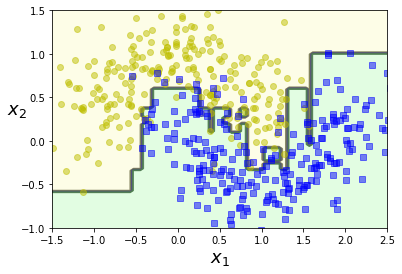

In [10]:
# plot and see what boosting does in the data
plot_decision_boundary(ada_clf, X, y)

### About Learning Rates

If I have time, would like to show just what it is learning rates do. See below a visual representation.

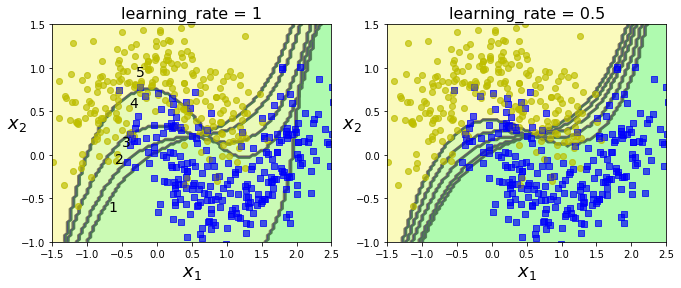

In [11]:
m = len(X_train)

plt.figure(figsize=(11, 4))

for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="auto", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
        
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

plt.show()

Learning rates have to do with how far the learner moves the decision boundary from any one point in data space inorder to better learn.

Higher the learning rate, faster the learner can discover new avenues to build decision boundaries in.

Lower the learning rate,m better the learner can explore local regions of high potential for an optimal decision boundary.

Chalo, back to the slides now.

Voleti.